In [144]:
import cv2
import numpy as np
import math
from scipy import ndimage, signal
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.filters import gaussian
import ActiveShapeModel 
import scipy
from scipy import ndimage

from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from skimage.filters import rank
from skimage import exposure

from skimage.filters import roberts, sobel, scharr, prewitt
from skimage import feature


def gaussian_filter(sigma, filter_length=None):
    '''
    Given a sigma, return a 1-D Gaussian filter.
    @param     sigma:         float, defining the width of the filter
    @param     filter_length: optional, the length of the filter, has to be odd
    @return    A 1-D numpy array of odd length, 
               containing the symmetric, discrete approximation of a Gaussian with sigma
               Summation of the array-values must be equal to one.
    '''
    if filter_length==None:
        #determine the length of the filter
        filter_length= math.ceil(sigma*5) 
        #make the length odd
        filter_length= 2*(int(filter_length)/2) +1   
    
    #make sure sigma is a float
    sigma=float(sigma)
    
    #create the filter
    result = np.zeros( int(filter_length) )
    
    #do your best!
    result = signal.gaussian(filter_length, std=sigma)
    result = result / np.sum(result)
       
    #return the filter
    return result

    
def gaussian_smooth1(img, sigma): 
    '''
    Do gaussian smoothing with sigma.
    Returns the smoothed image.
    '''
    result = np.zeros_like(img)
    
    #get the filter
    filter = gaussian_filter(sigma,3)
        
    pic = img.reshape(-1)
    new = np.convolve(pic,filter,'same')
    result = new.reshape(img.shape)
    
    return result


def sharpening(img): 
    
    k = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    #image_sharpen = scipy.signal.convolve2d(img, k, 'same')
    #ndimage.convolve(img, k, mode='constant', cval=0.0)
    image_sharpen = cv2.filter2D(img,-1,k)
    
    return image_sharpen


def sharpening2(img): 
    
    k1 = np.array([[1,1,1],[1,1,1],[1,1,1]])/9
    smoothed = cv2.filter2D(img,-1,k1)
    
    k2 = np.array([[0,0,0],[0,2,0],[0,0,0]])
    dubbel = cv2.filter2D(img,-1,k2)
    
    return 2*img - smoothed


def pre_processing(img):
    img = ActiveShapeModel.radiograph_preprocess(img)
    return ActiveShapeModel.radiograph_preprocess2(img)
 

def contrast_stretching(img):
    # Contrast stretching
    #p2, p98 = np.percentile(img, (0, 20))
    return exposure.rescale_intensity(img, in_range=(0.075*255, 0.6*255))

def adaptive_equalization(img):
    # Adaptive Equalization
    return exposure.equalize_adapthist(img, clip_limit = 0.01, nbins = 50)

def local_equalization(img, size = 50):
    # Equalization
    selem = disk(size)
    return rank.equalize(img, selem=selem)

def median_filter(img, size = 9):
    return scipy.signal.medfilt(img, size).astype(np.uint8)

def edge_detection_low(img):
    
    return roberts(img)
    
def edge_detection_high(img):
    return sobel(img)


def calc_external_img(img):
    
    img = rgb2gray(img)
    
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    abs_sobel64f = np.absolute(sobelx64f)
    sobelx = np.uint8(abs_sobel64f)
    
    sobely64f = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    abs_sobel64f = np.absolute(sobely64f)
    sobely = np.uint8(abs_sobel64f)

    return -(sobelx + sobely)

def calc_external_img2(img): 

    img = np.array(img, dtype=np.uint16)
    kx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    Gx = cv2.filter2D(img,-1,kx)
    
    ky = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    Gy = cv2.filter2D(img,-1,ky)
    
    G = np.sqrt(Gx**2 + Gy**2)
    
    return -G


def show(img, size=7):
    fig, ax = plt.subplots(figsize=(size, size))
    plt.imshow(img, cmap=plt.cm.gray)
    plt.show()

    
def load_image():
    dir_radiographs = "_Data\Radiographs\*.tif"
    radiographs = ActiveShapeModel.load_files(dir_radiographs)
    radiograph = radiographs[0]
    return radiograph

In [145]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


def show_different_preperations(img):
    matplotlib.rcParams['font.size'] = 8

    # Load an example image
    median = median_filter(img)

    local_eq = local_equalization(median)

    contrast = contrast_stretching(median)

    adapt = adaptive_equalization(median)


    # Display results
    fig = plt.figure(figsize=(12, 7))
    axes = np.zeros((2, 4), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(local_eq, axes[:, 3])
    ax_img.set_title('local_equalization')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(contrast, axes[:, 1])
    ax_img.set_title('contrast_stretching')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(adapt, axes[:, 2])
    ax_img.set_title('adaptive_equalization')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('median_filter')

    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()
    
def show_diff_edge_detectors(img):
    matplotlib.rcParams['font.size'] = 8
    edge_roberts = roberts(img)
    edge_sobel = sobel(img)
    edge_scharr = scharr(img)
    edge_prewitt = prewitt(img)
    canny = feature.canny(img, sigma=0.5)

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True,
                             figsize=(10, 7))
    ax = axes.ravel()

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    
    ax[1].imshow(edge_prewitt, cmap=plt.cm.gray)
    ax[1].set_title('Prewitt Edge Detection')

    ax[2].imshow(edge_scharr, cmap=plt.cm.gray)
    ax[2].set_title('Scharr Edge Detection')

    ax[3].imshow(edge_sobel, cmap=plt.cm.gray)
    ax[3].set_title('Sobel Edge Detection')

    ax[4].imshow(edge_roberts, cmap=plt.cm.gray)
    ax[4].set_title('Roberts Edge Detection')
    
    ax[5].imshow(canny, cmap=plt.cm.gray)
    ax[5].set_title('Canny Edge Detection')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

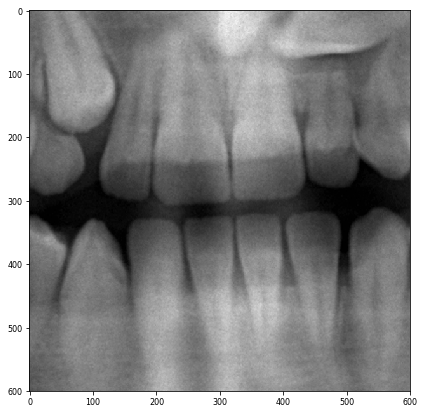

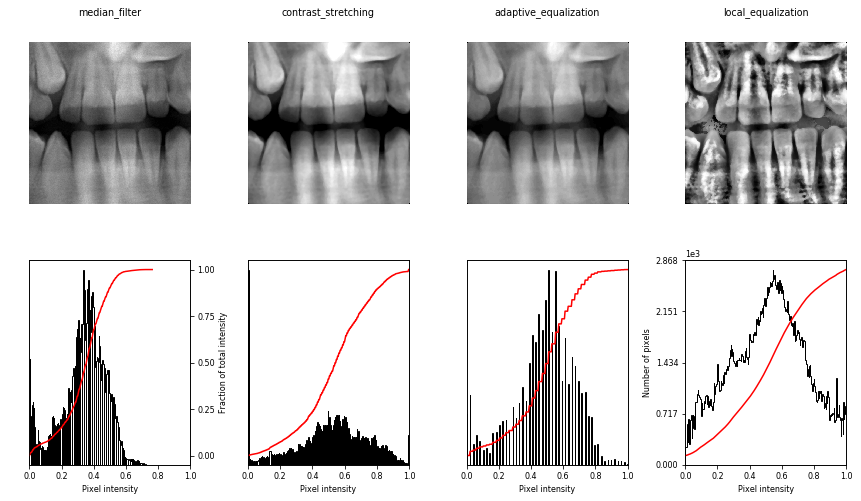

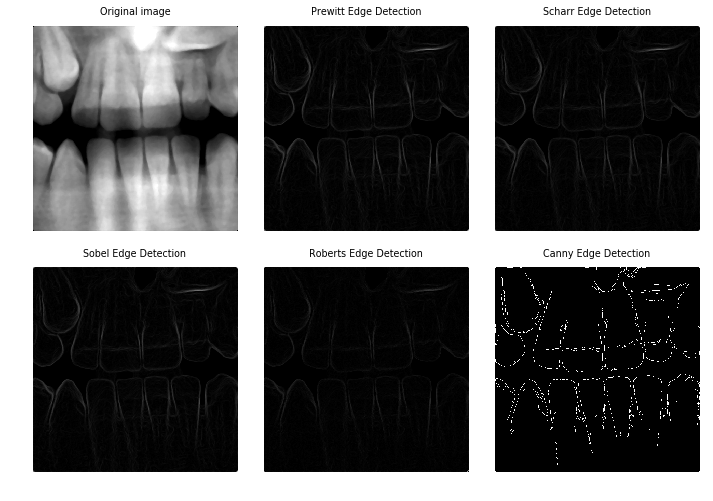

In [146]:
if __name__ == "__main__":
    
    img = load_image()
    piece = img[700:1300,1200:1800]
    show(piece, 7)
    
    median = median_filter(piece)
    contrast = contrast_stretching(median)
    
    show_different_preperations(piece)
    show_diff_edge_detectors(contrast)
